Используя np.random научиться сэмплировать случайные точки из двумерного нормального распределения. В качестве параметров двух разных нормальных распределений взять mu_0=(-1, -1) и mu_1 = (1, 1), с единичными дисперсиями

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [2]:
rng = np.random.default_rng()
data_0 = np.concatenate([rng.normal((-1, -1), 1, (50, 2)), np.zeros((50, 1))], axis=1)

In [3]:
rng = np.random.default_rng()
data_1 = np.concatenate([rng.normal((1, 1), 1, (50, 2)), np.ones((50, 1))], axis=1)

In [4]:
def random_mix(X, Y):
    c = np.concatenate((X, Y))
    np.random.shuffle(c)
    return c

In [5]:
data = random_mix(data_0, data_1)

In [6]:
X = data[:, [0, 1]]

In [7]:
T = data[:, [2]]
print(T.T)

[[1. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 1.
  0. 1. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1.
  0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1.
  1. 1. 0. 0. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 0. 1. 1.
  1. 0. 0. 0.]]


In [8]:
def sigmoid(z): # функция активации сигмоида
    return 1./(1+np.exp(-z))

Заменить функцию ошибки MSE на LogLoss.

In [9]:
def log_loss(t, y):
    loss = -(y * np.log(t) + (1 - y) * np.log(1-t))
    return loss

In [10]:
def diff_log_loss(t, y): # производная функции потерь
    return (-y / t) + ((1 - y) / (1 - t))

In [11]:
class Layer: # создаем класс 
    def __init__(self, n_inp, n_out, lr=0.01): # инициализируем необходимые параметры
        self.shape = (n_inp, n_out) # кол-во входных и выходных нейронов
        self.lr = lr
        self.w = np.zeros(self.shape, dtype=np.float32) # инициализируем вектор весов нулями
        self.b = np.zeros((1, n_out), dtype=np.float32) # инициализируем bias (смещение) нулем
        self._clear_grads()

    def _clear_grads(self): # функция очистки градиентов
        self.inp = None
        self.activations = None
        self.d_sigma = None
        self.d_w = None
        self.d_b = None

    def __call__(self, x): # функция прямого прохода
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        self.inp = x
        self.activations = sigmoid(x.dot(self.w) + self.b)
        return self.activations

    def backward(self, grad): # функция обратного прохода
        self.d_sigma = self.activations * (1 - self.activations) # производная сигмоиды
        self.d_w = self.grad_w(grad)
        self.d_b = self.grad_b(grad)
        return self.grad_x(grad)

    def grad_w(self, grad): # функции вычисления градиентов
        return grad * self.inp.T * self.d_sigma

    def grad_b(self, grad):
        return grad * self.d_sigma

    def grad_x(self, grad):
        return self.w.dot(grad) * self.d_sigma

    def step(self): # функция обновления весов
        self.w -= self.d_w * self.lr
        self.b -= self.d_b * self.lr
        self._clear_grads()

    def bin_result(self, act_out):
        if act_out < 0.5:
            return 0.0
        else:
            return 1.0

In [12]:
l1 = Layer(2, 1) # создаем однослойную нейронную сеть (2 входных нейрона, 1 выходной)

In [13]:
l1.shape

(2, 1)

In [14]:
print(l1.w)

[[0.]
 [0.]]


Обучить модель на примерах из этих распределений "предсказывать" 0 и 1 соответственно для первого и второго распределений.

In [15]:
for i in range(10000):
    j = 0
    for x in X:
        y = l1(x)
        d_y = diff_log_loss(y, T[j])
        l1.backward(d_y)
        l1.step()
        j += 1

In [16]:
predictions = []
for x in X:
    predictions.append(l1.bin_result(l1(x)))
print(accuracy_score(predictions, T))

0.96


Используя библиотеку matplotlib нарисовать разделяющую поверхность.

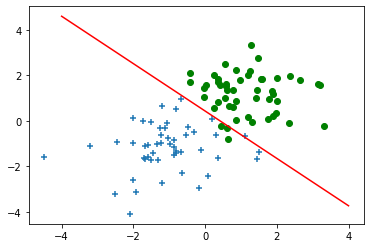

In [17]:
fig = plt.figure()

x0_samples = data_0[:, [0, 1]]
x1_samples = data_1[:, [0, 1]]

plt.scatter(x0_samples[:,0],x0_samples[:,1], marker='+')
plt.scatter(x1_samples[:,0],x1_samples[:,1], c= 'green', marker='o')
plt.plot()
X_ = np.linspace(-4, 4, 100)
Y_ = - l1.w[0][0] /  l1.w[1][0] * X_ + (0.5 - l1.b[0][0]) / l1.w[1][0]
plt.plot(X_, Y_, '-r')

Заменить однослойную нейронную сеть двухслойной

In [18]:
class LayerM: # создаем класс 
    def __init__(self, n_inp, n_out, lr=0.01): # инициализируем необходимые параметры
        self.shape = (n_inp, n_out) # кол-во входных и выходных нейронов
        self.lr = lr
        self.w = np.zeros(self.shape, dtype=np.float32) # инициализируем вектор весов нулями
        self.b = np.zeros((1, n_out), dtype=np.float32) # инициализируем bias (смещение) нулем
        self._clear_grads()

    def _clear_grads(self): # функция очистки градиентов
        self.inp = None
        self.activations = None
        self.d_sigma = None
        self.d_w = None
        self.d_b = None

    def __call__(self, x): # функция прямого прохода
        if len(x.shape) == 1:
            x = x.reshape(1, -1)
        self.inp = x
        self.activations = sigmoid(x.dot(self.w) + self.b)
        return self.activations

    def backward(self, grad): # функция обратного прохода
        self.d_sigma = self.activations * (1 - self.activations)
        self.delta = grad * self.d_sigma
        self.d_w = self.inp.T @ self.delta
        self.d_b = self.delta * 1
        return np.sum(self.delta @ self.w.T)

    def grad_w(self, grad): # функции вычисления градиентов
        return grad * self.inp.T * self.d_sigma

    def grad_b(self, grad):
        return grad * self.d_sigma

    def grad_x(self, grad):
        return self.w.dot(grad) * self.d_sigma

    def step(self): # функция обновления весов
        self.w -= self.d_w * self.lr
        self.b -= self.d_b * self.lr
        self._clear_grads()

    def bin_result(self, act_out):
        if act_out < 0.5:
            return 0.0
        else:
            return 1.0

In [19]:
l1 = LayerM(2, 10)
l2 = LayerM(10, 1)
for i in range(5000):
    j = 0
    for x in X:
        y = l1(x)
        z = l2(y)
        d_z = diff_log_loss(z, T[j])
        b2 = l2.backward(d_z)
        l1.backward(b2)
        l2.step()
        l1.step()
        j += 1

In [20]:
def two_layers_predict(inp, layers):
    layer1, layer2 = layers
    h = layer1(inp)
    y = layer2(h)
    return y

In [21]:
predictions = []
for x in X:
    predictions.append(l1.bin_result(two_layers_predict(x, (l1, l2))))
print(accuracy_score(predictions, T))

0.96
